In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model, Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D, AveragePooling2D, Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers.advanced_activations import LeakyReLU, ReLU

In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 3s 0us/step


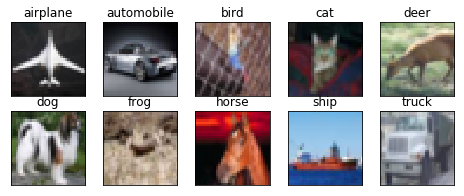

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [0]:
model_input = Input(shape=(32, 32, 3,))

## Block_1 5x5
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_1', dilation_rate=(1, 1), use_bias=False)(model_input)
x = BatchNormalization(name='norm_1')(x)
x = ReLU()(x)
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_2', dilation_rate=(2, 2), use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = ReLU()(x)
skip_connection_1 = x

## Block_2 5x5
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_3', dilation_rate=(1, 1), use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = ReLU()(x)
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_4', dilation_rate=(2, 2), use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = ReLU()(x)
skip_connection_2 = x

## Block_3 5x5
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_5', dilation_rate=(1, 1), use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = ReLU()(x)
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_6', dilation_rate=(2, 2), use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = ReLU()(x)
skip_connection_3 = x


x = concatenate([skip_connection_1, x])
x = Conv2D(8, (1,1), strides=(1,1), padding='same', name='1x1_conv_1', use_bias=False)(x)
x = BatchNormalization(name='1x1_norm_1')(x)
x = ReLU()(x)
## Block_4 5x5
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_7', dilation_rate=(1, 1), use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = ReLU()(x)
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_8', dilation_rate=(2, 2), use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = ReLU()(x)
skip_connection_4 = x


x = concatenate([skip_connection_1, x])
x = Conv2D(8, (1,1), strides=(1,1), padding='same', name='1x1_conv_2', use_bias=False)(x)
x = BatchNormalization(name='1x1_norm_2')(x)
x = ReLU()(x)
## First Max Pooling
x = MaxPooling2D(pool_size=(2, 2))(x)
skip_connection_1 = Lambda(space_to_depth_x2)(skip_connection_1)
skip_connection_2 = Lambda(space_to_depth_x2)(skip_connection_2)
skip_connection_3 = Lambda(space_to_depth_x2)(skip_connection_3)
skip_connection_4 = Lambda(space_to_depth_x2)(skip_connection_4)


## Block_5 3x3
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_9', dilation_rate=(1, 1), use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = ReLU()(x)
skip_connection_5 = x


x = concatenate([skip_connection_1, skip_connection_4, x])
x = Conv2D(8, (1,1), strides=(1,1), padding='same', name='1x1_conv_3', use_bias=False)(x)
x = BatchNormalization(name='1x1_norm_3')(x)
x = ReLU()(x)
## Block_6 5x5
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_10', dilation_rate=(1, 1), use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = ReLU()(x)
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_11', dilation_rate=(1, 1), use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = ReLU()(x)
skip_connection_6 = x


x = concatenate([skip_connection_3, skip_connection_4, skip_connection_5, x])
x = Conv2D(8, (1,1), strides=(1,1), padding='same', name='1x1_conv_4', use_bias=False)(x)
x = BatchNormalization(name='1x1_norm_4')(x)
x = ReLU()(x)
## Block_7 3x3
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_12', dilation_rate=(1, 1), use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = ReLU()(x)
skip_connection_7 = x


x = concatenate([skip_connection_3, skip_connection_4, skip_connection_5, skip_connection_6, x])
x = Conv2D(8, (1,1), strides=(1,1), padding='same', name='1x1_conv_5', use_bias=False)(x)
x = BatchNormalization(name='1x1_norm_5')(x)
x = ReLU()(x)
## Block_8 5x5
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_13', dilation_rate=(1, 1), use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = ReLU()(x)
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_14', dilation_rate=(1, 1), use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = ReLU()(x)


x = concatenate([skip_connection_1, skip_connection_4, skip_connection_5, skip_connection_7, x])
x = Conv2D(8, (1,1), strides=(1,1), padding='same', name='1x1_conv_6', use_bias=False)(x)
x = BatchNormalization(name='1x1_norm_6')(x)
x = ReLU()(x)
## Second Max Pooling
x = MaxPooling2D(pool_size=(2, 2))(x)
skip_connection_1 = Lambda(space_to_depth_x2)(skip_connection_1)
skip_connection_2 = Lambda(space_to_depth_x2)(skip_connection_2)
skip_connection_3 = Lambda(space_to_depth_x2)(skip_connection_3)
skip_connection_4 = Lambda(space_to_depth_x2)(skip_connection_4)
skip_connection_5 = Lambda(space_to_depth_x2)(skip_connection_5)
skip_connection_6 = Lambda(space_to_depth_x2)(skip_connection_6)
skip_connection_7 = Lambda(space_to_depth_x2)(skip_connection_7)


x = concatenate([skip_connection_6, x])
x = Conv2D(8, (1,1), strides=(1,1), padding='same', name='1x1_conv_7', use_bias=False)(x)
x = BatchNormalization(name='1x1_norm_7')(x)
x = ReLU()(x)
## Block_9 5x5
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_15', dilation_rate=(1, 1), use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = ReLU()(x)
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_16', dilation_rate=(1, 1), use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = ReLU()(x)
skip_connection_9 = x


x = concatenate([skip_connection_1, skip_connection_2, skip_connection_7, x])
x = Conv2D(8, (1,1), strides=(1,1), padding='same', name='1x1_conv_10', use_bias=False)(x)
x = BatchNormalization(name='1x1_norm_10')(x)
x = ReLU()(x)
## Block_10 5x5
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_17', dilation_rate=(1, 1), use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = ReLU()(x)
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_18', dilation_rate=(1, 1), use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = ReLU()(x)
skip_connection_10 = x


x = concatenate([skip_connection_2, skip_connection_3, skip_connection_5, skip_connection_9, x])
x = Conv2D(8, (1,1), strides=(1,1), padding='same', name='1x1_conv_11', use_bias=False)(x)
x = BatchNormalization(name='1x1_norm_11')(x)
x = ReLU()(x)
## Block_11 3x3
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_19', dilation_rate=(1, 1), use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = ReLU()(x)

x = concatenate([skip_connection_1, skip_connection_3, skip_connection_4, skip_connection_5, skip_connection_7, skip_connection_10, x])
x = Conv2D(8, (1,1), strides=(1,1), padding='same', name='1x1_conv_12', use_bias=False)(x)
x = BatchNormalization(name='1x1_norm_12')(x)
x = ReLU()(x)
## Block_12 5x5
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_20', dilation_rate=(1, 1), use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = ReLU()(x)
x = Conv2D(8, (3,3), strides=(1,1), padding='same', name='conv_21', dilation_rate=(1, 1), use_bias=False)(x)
x = BatchNormalization(name='norm_21')(x)
x = ReLU()(x)

## Last layer for softmax
x = concatenate([skip_connection_4, skip_connection_7, skip_connection_10, x])

x = Conv2D(10, (1,1), strides=(1,1), padding='same', name='1x1_conv_13', use_bias=False)(x)
x = BatchNormalization(name='1x1_norm_13')(x)
x = ReLU()(x)
x = Conv2D(10, (8,8), name='conv_22', use_bias=False)(x)

x = Flatten()(x)

output = Activation('softmax')(x)

#model = Model(inputs=model_input, outputs=output)
model = Model(inputs=[model_input], outputs=[output])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

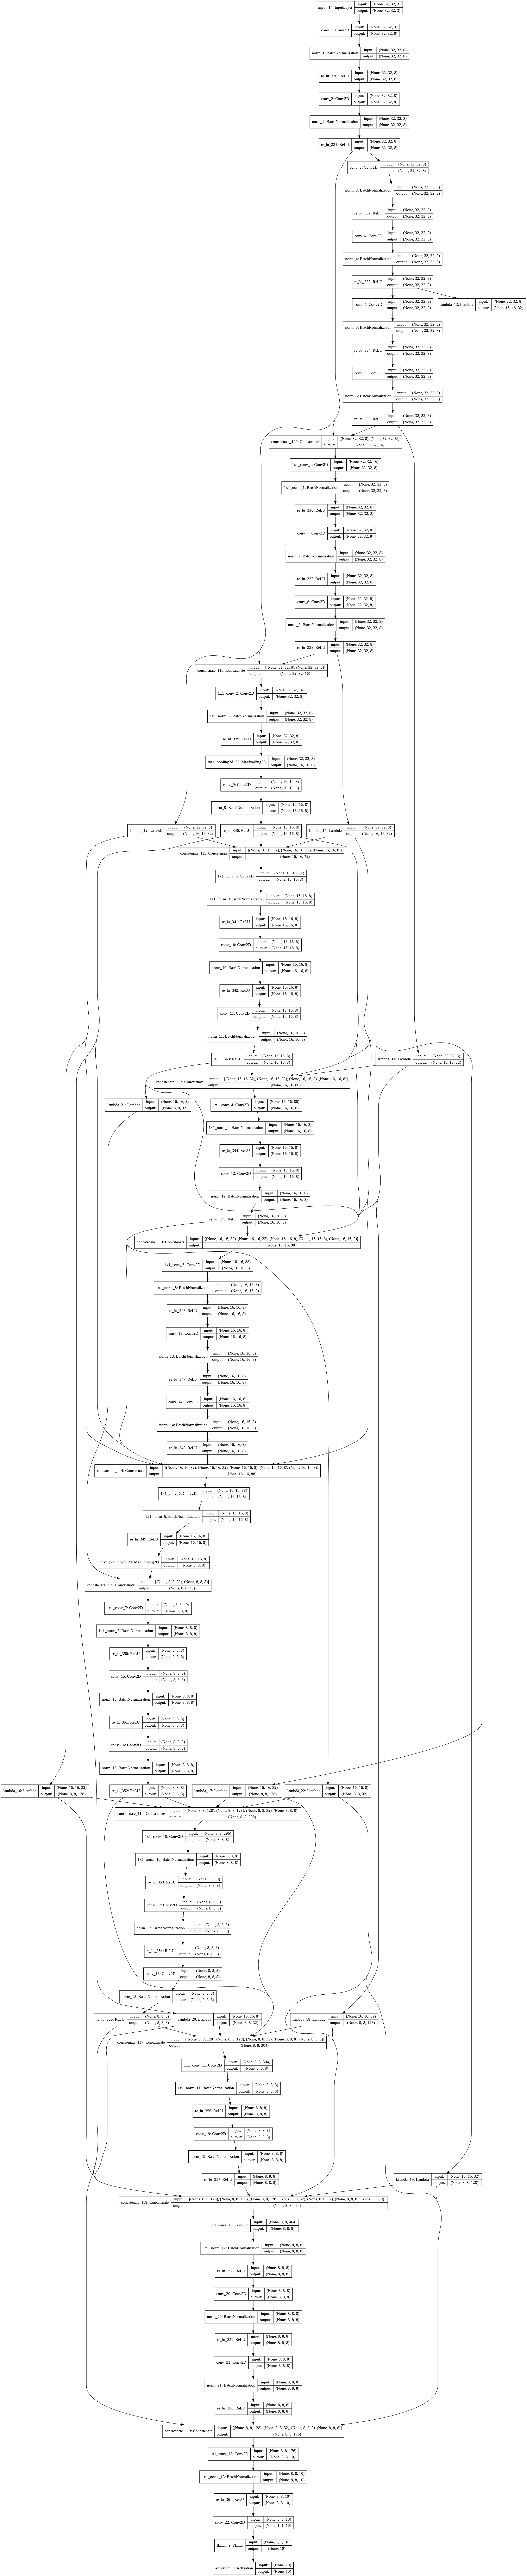

In [29]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 32, 32, 8)    216         input_14[0][0]                   
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 32, 32, 8)    32          conv_1[0][0]                     
__________________________________________________________________________________________________
re_lu_330 (ReLU)                (None, 32, 32, 8)    0           norm_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Co

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=12, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
12/12 [==============================] - 24s 2s/step - loss: 1.3542 - acc: 0.5111 - val_loss: 1.4914 - val_acc: 0.4581
Epoch 2/100
12/12 [==============================] - 19s 2s/step - loss: 1.3317 - acc: 0.5191 - val_loss: 1.4559 - val_acc: 0.4723
Epoch 3/100
12/12 [==============================] - 19s 2s/step - loss: 1.3044 - acc: 0.5296 - val_loss: 1.4475 - val_acc: 0.4745
Epoch 4/100
12/12 [==============================] - 19s 2s/step - loss: 1.2918 - acc: 0.5326 - val_loss: 1.4818 - val_acc: 0.4627
Epoch 5/100
12/12 [==============================] - 19s 2s/step - loss: 1.2706 - acc: 0.5415 - val_loss: 1.4540 - val_acc: 0.4749
Epoch 6/100
12/12 [==============================] - 19s 2s/step - loss: 1.2568 - acc: 0.5471 - val_loss: 1.4376 - val_acc: 0.4812
Epoch 7/100
12/12 [==============================] - 19s 2s/step - loss: 1.2268 - acc: 0.5583 - val_loss: 1.4171 - val_acc: 0.4944
Epoch 8/100
12/12 [==============================] - 19s 2s/step - loss: 1.2160 - a

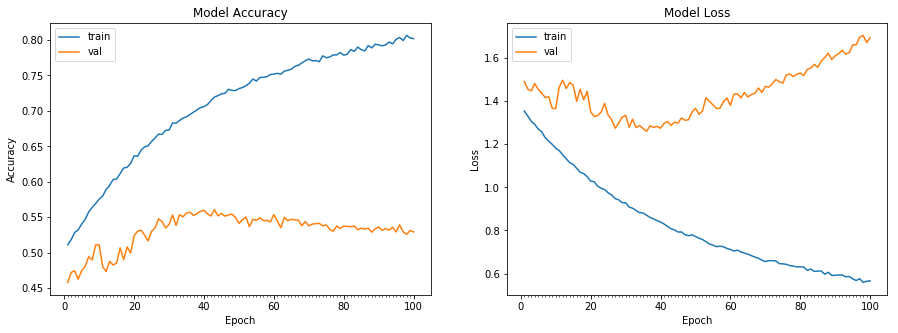

Accuracy on test data is: 52.93


In [33]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 4096),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))